# EEBO Word Embeddings

Helen Liang
<br>
Last updated: 12/2/2020
<br>

#### *Updates*: 
- Topic modeling
- Cleaning notebook

In [57]:
import sys
import os
from glob import glob
from pathlib import Path
import regex
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
import math
import pickle
from collections import Counter
from nltk.corpus import stopwords

# Introduction
In this project, we are modeling change in the same English word from the Early Modern English period.
<br>
English is an unstable language, with spellings, usage, and word frequencies changing rapidly over short periods of time. Even within the same time period, there are many variation of the same word, lacking a consistent spelling. Because of the instability of English, we are interested in seeing how the meaning of words change over time using word embeddings. 
<br> 
There is relatively more stability in Early Modern English than Old or Middle English, hence the choice of early modern english texts. Our early modern corpus is [EEBO](https://quod.lib.umich.edu/e/eebogroup/), which will be compared with books from 1800-1990.

In [17]:
ALL_DIR = 'date_txt/all/'
def extract_year(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.endswith('.xml'):
                continue
            f_name = (os.path.join(root, file))
            with open(f_name, 'r') as f:
                line = f.readline()
                while line and '<date>' not in line: 
                    line = f.readline() 
                searcher = re.search('(?<=<date>)[0-9]+(?=.*<\/date>)', line) # match the first date that occurs between the tags <date> </date>
                if not searcher:
                    print(f_name)
                year = searcher.group(0)
                century = year[:2] + "00"
                path = os.path.join('date_txt', century)
                os.makedirs(path, exist_ok = True) 
            with open(os.path.join(path, Path(file).stem + ".txt"), 'w') as f:
                f.write(year)
            os.makedirs(ALL_DIR, exist_ok = True)
            with open(os.path.join(ALL_DIR, Path(file).stem + ".txt"), 'w') as f:
                f.write(year)


In [18]:
eebo = extract_year('xml')

In [27]:
print(len(glob('date_txt/all/*')))

25370


In [29]:
print(len(glob('balanced_txt/**/*.txt')))

20076


In [31]:
print(len(glob('no_punct/*.txt')))

19946


In [23]:
print(len(glob('xml/*')))

25373


## Preprocessing

To preprocess the text, we must first strip punctuation. A modified strip_punct.py script was run on all_text_v1_v2.txt 
(all of the EEBO text in one file) to create all_text_v1_v2_nopunct.txt, a clean version of all_text_v1_v2.txt with all non-words removed. A demo of strip punctuation is shown below. 

In [4]:
eebo[-1]

'balanced_txt/050/A00778.headed.txt'

In [6]:
def strip_punct(directory):
    token_pattern = regex.compile("(\w[\w\'\-]*\w|\w)")
    print(directory)
    for f_name in glob(directory + "**/*.txt"):
        with open(f_name, 'r') as reader:
            os.makedirs('no_punct', exist_ok = True) 
            with open(os.path.join('no_punct', os.path.basename(f_name)), 'a+') as writer: 
                for line in reader: 
                    line = line.lower().replace("∣", "")
                    tokens = token_pattern.findall(line)
                    writer.write(" ".join(tokens) + "\n")

In [15]:
strip_punct('balanced_txt/')

balanced_txt/


In [34]:
strip_punct('balanced_txt/')

balanced_txt/
balanced_txt/000/B30830.headed.txt
T1987A [ocm]18719324 205392
AN Epistle of Love TO Friends in the Womens Meetings in London, &c. To be read among them in the fear of God. DEar Friends and Sisters in Christ Jesus to you is the salu∣tation of my true and sincere Love, in the ever blessed pure and precious truth of our God: and to you is my Heart open, in the tender love of our heavenly Fa∣ther, who hath reached unto us, and lifted up the light of his countenance upon us, and caused the ever blessed light, of his everlasting day to shine among us; and hath made known the riches of his grace unto us, in order to fit and prepare us for his own work and service: To you my wellbeloved in the Lord, doth my Love and Life reach at this time; to you that are given up to serve the Lord his Truth and People; with chearfullness of Heart and readiness of mind, according to the measure of his grace committed unto you; and the breathings of my Soul unto the God of my Life is, that he ma

In [14]:
# Uncomment this
strip_punct('balanced_txt/000/A00268.headed.txt')

10376 99847128 12146
articles to be enquired off within the prouince of yorke in the metropoliticall visitation of the most reuerend father in go edwin archbishoppe of yorke primate of england and metropolitane in the xix and xx yeare of the raigne of our most gratious souereigne lady elizabeth by the grace of god of england fraunce and ireland queene defendor of the fayth c 1577 1578 imprinted at london by william seres
articles to be enqvired off within the prouince of yorke in the metropoliticall visitation of the most reuerend father in god edwin archbishoppe of yorke primate of england and metropolitane in the xix yeare of the raigne of our most gratious soueraigne lady elizabath by the grace of god of england fraunce and ireland queene defendour of the faith c first whether commō praier be sayd in your church or chappel vpon the sundaies holy dayes at conuenient houres reuerently distinctly and in such order without any kinde of alteration as is appoynted by the booke of commō 

## Nearest Words

The slurm script fasttext.sub was then run on all_text_v1_v2_nopunct.txt to generate the word embedding vectors. Fasttext.sub calls fasttext using the cbow model to output embeddings/sgns_v1_v2_d100_1.vec, the human readable version of word embeddings. Tokenization has already been done by fasttext. 

After the slurm job has completed, run nearest.py to find the 20 nearest words to the input word.

In [9]:
output = !python nearest.py embeddings/sgns_v1_v2_d100_1.vec true

In [27]:
def clean_output(output):
    #[^a-zA-Z-\']+
    return [re.sub('[\.0-9]+', '', s.replace('\t', '')) for s in output]

In [4]:
def read_vec_file(name):
    words_dict = dict()
    with open(name, "r") as file:
        for i, line in enumerate(file): 
            if i != 0: 
                line = line.strip().split(' ')
                words_dict[line[0]] = [float(n) for n in line[1:]]
        return words_dict
words_dict = read_vec_file('embeddings/sgns_v1_v2_d100_1.vec')

In [5]:
# Find nearest function from nearest.py
def find_nearest(input_word, embeddings, vocab):
    query_id = vocab.index(input_word)
    print(np.sqrt(np.sum(embeddings ** 2, axis=1)))
    normalizer = 1.0 / np.sqrt(np.sum(embeddings ** 2, axis=1))
    embeddings *= normalizer[:, np.newaxis]
    scores = np.dot(embeddings, embeddings[query_id,:])
    sorted_list = sorted(list(zip(scores, vocab)), reverse=True)
    
    nearest = []
    for score, word in sorted_list[0:20]:
        print("{:.3f}\t{}".format(score, word))
        nearest.append(word)

    return nearest

words_dict is a dictionary representation of the .vec file. Words from the corpus are keys and their respective vector representations are values. Take a look below. 

In [12]:
for k, v in words_dict.items():
    print(k)
    print(v)
    break

the
[-0.18489848, 0.06808506, 0.25595662, 0.17188543, 0.037654955, 0.0051366338, -0.04474668, -0.043178707, 0.04380905, -0.3671004, 0.15313336, -0.13872255, -0.49349466, 0.1728954, 0.18529195, 0.038108274, 0.20786463, 0.15146597, -0.044726238, 0.049716745, -0.26126888, -0.10828109, -0.04244245, 0.01174636, 0.04659954, 0.26178488, 0.08462093, -0.03321066, -0.020420447, -0.24766025, -0.050465543, -0.28281528, 0.13968821, -0.3628608, 0.07868071, 0.068998545, -0.056997843, 0.19090831, -0.15597442, 0.1672764, 0.20952386, -0.100779526, -0.08410791, 0.009130444, 0.17206787, -0.05249392, -0.14769125, -0.2557637, -0.14989932, -0.055034913, -0.27376437, 0.17862496, 0.06681945, -0.15870348, 0.055367753, -0.21392596, -0.24123484, 0.29547364, 0.22669992, 0.17882921, -0.22640234, -0.30965278, 0.16120891, 0.048422385, 0.05698442, 0.17416024, 0.13867001, -0.17245133, 0.11170741, -0.020344907, 0.06829954, 0.043494076, -0.08843164, -0.11732712, -0.2400157, 0.049039885, 0.06697231, 0.24299929, 0.3211362,

## Visualization
The EEBO word embeddings are visualized below. The green indicates the ranking of a neighbor word of how close it is to the input word according to nearest.py. The distance of a neighbor word to the input word is closeness determined by PCA. The words we will be looking at are 'true' and 'awe'.  

| Word   | Modern Meaning   | Expected ME Meaning
|--------|------------------|------------------
|true    | True (not False) |True/just/righteous
|awe     | awe/fear/terror  |awesome/amazing


The embeddings graph was created with help from [reference](https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354)

In [6]:
def visualize_embeddings(nearest_words, target_word, words_dict, title='Word Embedding Space'): 
    vectors = [words_dict[w] for w in nearest_words]
    two_dim = PCA(random_state=0).fit_transform(vectors)[:,:2]
    x_length = abs(max(two_dim[:,0]) - min(two_dim[:,0]))
    print(x_length)
    y_length = abs(max(two_dim[:,1]) - min(two_dim[:,1]))
    print(y_length)
    plt.figure(figsize=(13,7))
    plt.scatter(two_dim[:,0],two_dim[:,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title(title,size=20)
    for i, word in enumerate(nearest_words):
        if word == target_word:
            c = 'red'
        else:
            c = 'black'
        plt.annotate(word,xy=(two_dim[i,0]+0.02*x_length,two_dim[i,1]-0.015*y_length), color=c)
        
        plt.annotate(i,xy=(two_dim[i,0]+0.01*x_length,two_dim[i,1]-0.05*y_length), color = 'green')
    plt.annotate('input word', xy=two_dim[0], xytext=(two_dim[0,0]+0.5, two_dim[0,1]+0.5),
        arrowprops=dict(facecolor='red', shrink=0.05))

In [ ]:
output = clean_output(output)
visualize_embeddings(output, 'true', words_dict)

Some notable observations for 'true' in EEBO and PCA: 
<br> 
1. The word embeddings visualized above capture synonyms, alternate spellings, and co-occurrence. An example of a synonym is "truth" or "sincere". An example of alternate spelling is "trew" or "tru". An example of co-occurrence is christian and and certainly (i.e. true christian or certainly true)
<br> 
2. PCA and nearest neighbors have different similarity rankings. For example, the word "verity" is the 7th nearest word to true using dot product but after reducing vector dimensions down to 2, it is roughly the 2nd closest word. The PCA graph therefore is not a perfect visualization of the nearest words. 
3. Some clusters of words with similar meanings are revealed in this graph. The religious cluster on the top left with words such as faith and religion. There there "truth" and "verity" cluster on bottom left. "certainly" and "indeed" are synonyms and form the cluster meaning agreement on the bottom left. 

In [16]:
output_awe = !python nearest.py embeddings/sgns_v1_v2_d100_1.vec awe
output_awe = clean_output(output_awe)
print(output_awe)

['awe', 'awes', 'dread', 'awfull', 'awefull', 'aw', 'terrour', 'feare', 'awed', 'awful', 'terror', 'awd', 'tremble', 'terrifie', 'daunt', 'dreading', 'reverential', 'dreade', 'affright', 'overawe']


3.5739378722161357
4.018452160636973


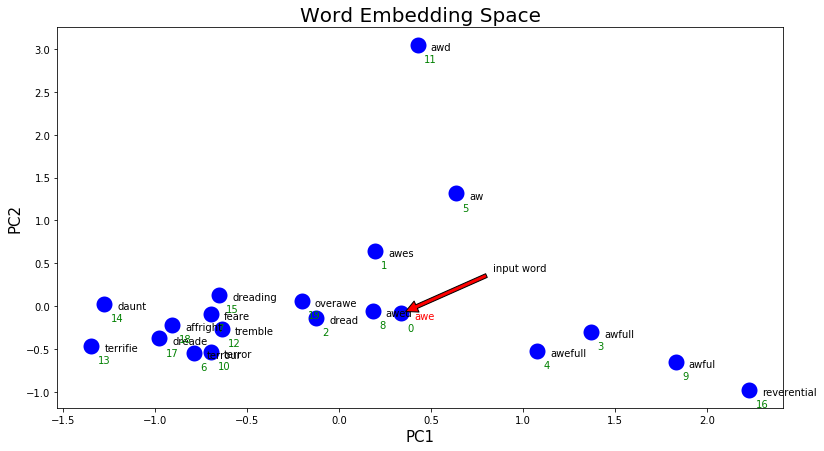

In [17]:
visualize_embeddings(output_awe, 'awe', words_dict)

Some notable clusters 'awe' in EEBO: 
<br>
1. Terror as a Synonym. The words "dreading", "feare", "tremble" in the bottom left corner form this definition. 
2. Bad as a Synonym. The cluster of various spellings of 'awful' in the bottom right form this cluster. 
3. Reverential as a Synonym. Despite being ranked as 16 (out of 20) and located in the far bottom right corner, 'reverential' could be an emerging definition for 'awe' that is more similar to the way we use 'awe' positively today. 

### Comparison with 1890 English History Corpus

The English History Corpus uses data and embeddings from [here](https://nlp.stanford.edu/projects/histwords/)

In [18]:
with open('sgns/1890-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [19]:
modern_embeddings = np.load('sgns/1890-w.npy')

[ 1.  1.  1. ... nan nan nan]
1.000	true
0.448	truth
0.389	genuine
0.385	false
0.376	ideal
0.365	nevertheless
0.359	essence
0.356	axiomatic
0.352	believed
0.349	demonstrably
0.348	meaning
0.347	reality
0.344	untrue
0.341	sincere
0.340	truer
0.340	faith
0.334	statement
0.332	real
0.331	correct
0.323	because
0.9873966504203289
0.856515680236961


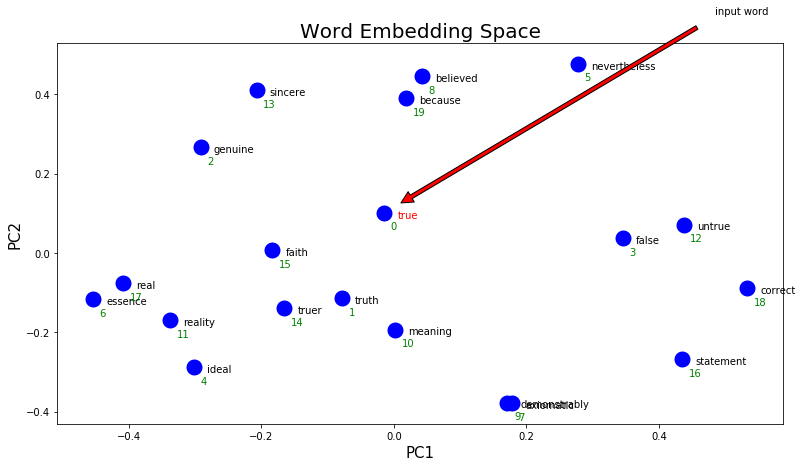

In [22]:
output_true = find_nearest('true', modern_embeddings, vocab)
output_true = clean_output(output_true)
true_dict = {w:modern_embeddings[vocab.index(w)] for w in output_true}
visualize_embeddings(output_true, 'true', true_dict)

Exciting to see that the meaning of 'true' has shifted a lot from ME to Late Modern English! 
Some things to note for 'true' in 1800:
<br>
1. The religious co-occurrence has mostly disappeared (as expected)! 'Faith' is the only word left and is ranked 15 out of 20.
2. Many, many new definitions of 'true' have emerged. This could in part be due to the greater diversity of modern day fiction texts and topics. 'True' today could mean 'real' (bottom left cluster) or 'truth' (middle bottom cluster) or correct/false (bottom right cluster) or genuine/sincere (top left cluster). 

[ 1.  1.  1. ... nan nan nan]
1.000	awe
0.536	reverence
0.514	terror
0.514	veneration
0.479	horror
0.460	dread
0.453	inspire
0.445	wonder
0.436	amazement
0.431	admiration
0.416	dismay
0.414	astonishment
0.408	superstitious
0.394	beholder
0.392	sadness
0.391	solemnity
0.381	inspiring
0.379	awful
0.375	speechless
0.375	inspired
0.9810345491670139
1.0859115367774033


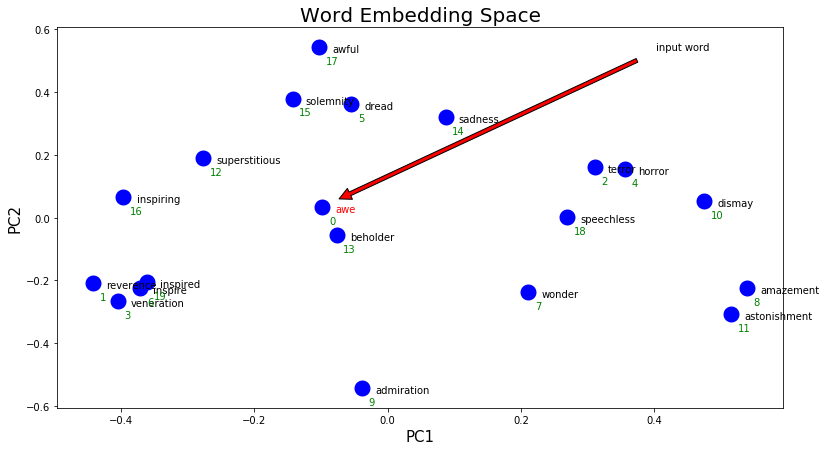

In [23]:
output_awe = find_nearest('awe', modern_embeddings, vocab)
output_awe = clean_output(output_awe)
awe_dict = {w:modern_embeddings[vocab.index(w)] for w in output_awe}
visualize_embeddings(output_awe, 'awe', awe_dict)

Similarly, 'awe' has also become overloaded with meaning in Late Modern English.
For example, some synonyms are amazement/astonishment in bottom right, reverence/inspired in the bottom left, sadness/awful in top middle, and terror/horror in the middle right. 

### Comparison with 1990 English History Corpus

In [30]:
with open('sgns/1990-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
modern_embeddings = np.load('sgns/1990-w.npy')

[ 1.  1.  1. ... nan nan nan]
1.000	true
0.482	false
0.441	truth
0.408	indeed
0.402	is
0.399	correct
0.397	though
0.390	converse
0.386	untrue
0.383	say
0.378	certainly
0.375	believe
0.371	believes
0.370	quite
0.367	inasmuch
0.361	discern
0.356	falsity
0.353	if
0.353	knows
0.350	whilst
1.0307229629381038
1.0102473530785536


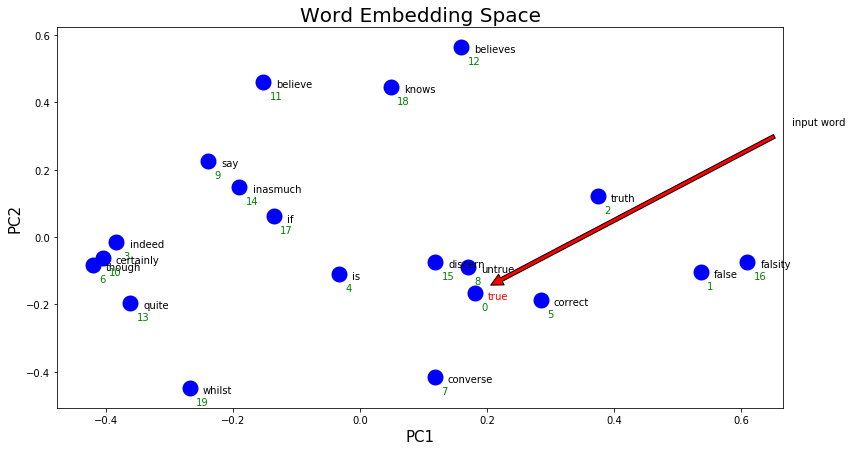

In [33]:
output_true = find_nearest('true', modern_embeddings, vocab)
output_true = clean_output(output_true)
true_dict = {w:modern_embeddings[vocab.index(w)] for w in output_true}
visualize_embeddings(output_true, 'true', true_dict)

[ 1.  1.  1. ... nan nan nan]
1.000	awe
0.535	reverence
0.519	astonishment
0.515	admiration
0.502	amazement
0.482	dread
0.457	wonder
0.444	horror
0.440	fascination
0.435	inspiring
0.434	delight
0.431	gazed
0.414	indignation
0.406	curiosity
0.404	dismay
0.404	gratitude
0.403	bewildered
0.401	feeling
0.401	contempt
0.400	sadness
0.9803908669641848
0.9156536351305079


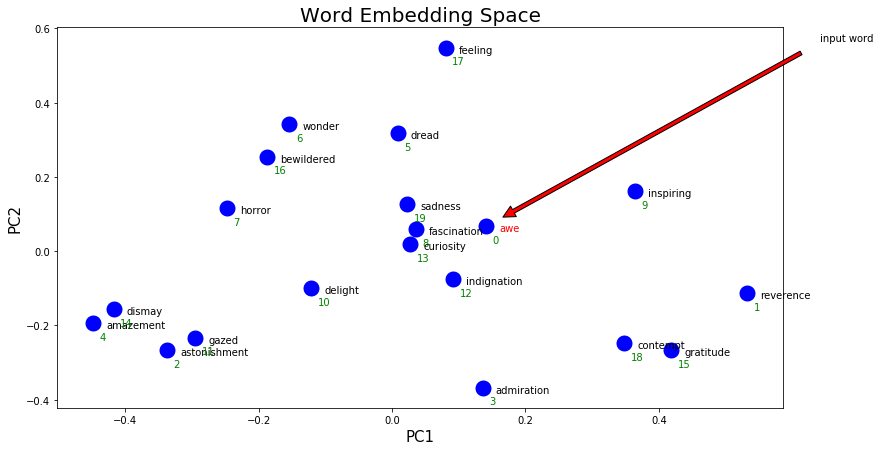

In [32]:
output_awe = find_nearest('awe', modern_embeddings, vocab)
output_awe = clean_output(output_awe)
awe_dict = {w:modern_embeddings[vocab.index(w)] for w in output_awe}
visualize_embeddings(output_awe, 'awe', awe_dict)

# Topic Modeling on EEBO

## Tokenization

In [ ]:
import random
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

tokens = []
with open(sys.argv[1]) as reader:
    for line in reader: 
        if random.randint(0, 15) == 1: # Original text too large, take only 1/15 of it 
            line_tokens = [token for token in line.split(' ') if len(token) > 2 and token not in stop_words]
            tokens.append(line_tokens)
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text_lst) for text_lst in tokens]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')

## LDA Topic Modeling

In [ ]:
## This is better run as a slurm job
NUM_TOPICS = 7
corpus = pickle.load(open('corpus.pkl', 'rb'))
dictionary = corpora.Dictionary.load('dictionary.gensim')
ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10, workers=4)
ldamodel.save('model4.gensim')

In [4]:
corpus = pickle.load(open('corpus.pkl', 'rb'))
dictionary = corpora.Dictionary.load('dictionary.gensim')
counts = Counter(dictionary.cfs)
for w, c in counts.most_common(100):
    print(dictionary[w])

god
may
one
shall
upon
man
hath
yet
great
christ
men
good
would
made
first
also
lord
time
thou
much
many
haue
must
make
thy
said
king
things
church
therefore
without
unto
say
like
well
come
two
see
doth
might
let
vnto
take
people
life
though
day
world
place
thing
thus
part
could
hee
power
true
way
thee
faith
called
word
others
death
holy
another
every
doe
know
law
cannot
saith
reason
gods
bee
spirit
nothing
put
body
done
name
onely
cause
nature
little
never
set
vpon
love
words
give
father
long
self
whole
heart
grace
either
came
end
taken


In [13]:
len(dictionary)

1170057

In [14]:
dictionary.filter_extremes(no_above=0.5)

In [15]:
len(dictionary)

100000

In [2]:
ldamodel = gensim.models.ldamodel.LdaModel.load('model4.gensim')
topics = ldamodel.print_topics(num_words=20)
for topic in topics:
    print(topic)
    print('\n')

(0, '0.011*"god" + 0.010*"haue" + 0.007*"hee" + 0.007*"vnto" + 0.006*"bee" + 0.006*"doe" + 0.006*"man" + 0.006*"shall" + 0.005*"hath" + 0.005*"may" + 0.005*"one" + 0.005*"yet" + 0.005*"vpon" + 0.005*"good" + 0.005*"wee" + 0.004*"men" + 0.004*"christ" + 0.004*"thou" + 0.004*"owne" + 0.004*"himselfe"')


(1, '0.010*"haue" + 0.008*"whiche" + 0.008*"vnto" + 0.007*"hym" + 0.006*"god" + 0.005*"also" + 0.005*"theyr" + 0.005*"lorde" + 0.005*"man" + 0.004*"thou" + 0.004*"shall" + 0.004*"men" + 0.004*"tyme" + 0.004*"hys" + 0.004*"suche" + 0.003*"good" + 0.003*"made" + 0.003*"one" + 0.003*"sayd" + 0.003*"shal"')


(2, '0.007*"one" + 0.007*"water" + 0.007*"may" + 0.006*"two" + 0.005*"also" + 0.005*"take" + 0.004*"like" + 0.004*"part" + 0.004*"parts" + 0.004*"make" + 0.004*"little" + 0.004*"first" + 0.004*"much" + 0.004*"body" + 0.003*"great" + 0.003*"must" + 0.003*"three" + 0.003*"made" + 0.003*"upon" + 0.003*"called"')


(3, '0.015*"est" + 0.013*"non" + 0.007*"per" + 0.007*"quod" + 0.007*"qui" + 

Evaluate our LDA model using u-mass coherence score. The closer to 0 the better.

In [3]:
corpus = pickle.load(open('corpus.pkl', 'rb'))
dictionary = corpora.Dictionary.load('dictionary.gensim')
coherence_model_lda = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score: ', coherence_lda)


 Coherence Score:  -1.7368693174812166


## Mimno's Topic Model

In [27]:
num_topics = 100
doc_smoothing = 0.5
word_smoothing = 0.01

In [10]:
import numpy as np
%load_ext cython

import re, sys, random, math
from collections import Counter
from timeit import default_timer as timer
from IPython.display import display, clear_output, Markdown, Latex

from matplotlib import pyplot

word_pattern = re.compile("\w[\w\-\']*\w|\w")

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [30]:
%%cython
from cython.view cimport array as cvarray
import numpy as np
import random
from timeit import default_timer as timer

class Document:
    
    def __init__(self, long[:] doc_tokens, long[:] doc_topics, long[:] topic_changes, long[:] doc_topic_counts):
        self.doc_tokens = doc_tokens
        self.doc_topics = doc_topics
        self.topic_changes = topic_changes
        self.doc_topic_counts = doc_topic_counts

cdef class TopicModel:
    
    cdef long[:] topic_totals
    cdef long[:,:] word_topics
    cdef int num_topics
    cdef int vocab_size
    
    cdef double[:] topic_probs
    cdef double[:] topic_normalizers
    cdef float doc_smoothing
    cdef float word_smoothing
    cdef float smoothing_times_vocab_size
    
    documents = []
    vocabulary = []
    
    def __init__(self, num_topics, vocabulary, doc_smoothing, word_smoothing):
        self.num_topics = num_topics
        self.vocabulary.extend(vocabulary)
        self.vocab_size = len(vocabulary)
        
        self.doc_smoothing = doc_smoothing
        self.word_smoothing = word_smoothing
        self.smoothing_times_vocab_size = word_smoothing * self.vocab_size
        
        self.topic_totals = np.zeros(num_topics, dtype=int)
        self.word_topics = np.zeros((self.vocab_size, num_topics), dtype=int)
    
    def clear_documents(self):
        self.documents.clear()
    
    def add_document(self, doc):
        cdef int word_id, topic
        
        self.documents.append(doc)
        
        for i in range(len(doc.doc_tokens)):
            word_id = doc.doc_tokens[i]
            topic = random.randrange(self.num_topics)
            doc.doc_topics[i] = topic
            
            self.word_topics[word_id,topic] += 1
            self.topic_totals[topic] += 1
            doc.doc_topic_counts[topic] += 1
            
    def sample(self, iterations):
        cdef int old_topic, new_topic, word_id, topic, i, doc_length
        cdef double sampling_sum = 0
        cdef double sample
        cdef long[:] word_topic_counts
        
        cdef long[:] doc_tokens
        cdef long[:] doc_topics
        cdef long[:] doc_topic_counts
        cdef long[:] topic_changes
        
        cdef double[:] uniform_variates
        cdef double[:] topic_probs = np.zeros(self.num_topics, dtype=float)
        cdef double[:] topic_normalizers = np.zeros(self.num_topics, dtype=float)
        
        for topic in range(self.num_topics):
            topic_normalizers[topic] = 1.0 / (self.topic_totals[topic] + self.smoothing_times_vocab_size)
        
        for iteration in range(iterations):
            for document in self.documents:
                doc_tokens = document.doc_tokens
                doc_topics = document.doc_topics
                doc_topic_counts = document.doc_topic_counts
                topic_changes = document.topic_changes
                
                doc_length = len(document.doc_tokens)
                uniform_variates = np.random.random_sample(doc_length)
                
                for i in range(doc_length):
                    word_id = doc_tokens[i]
                    old_topic = doc_topics[i]
                    word_topic_counts = self.word_topics[word_id,:]
        
                    ## erase the effect of this token
                    word_topic_counts[old_topic] -= 1
                    self.topic_totals[old_topic] -= 1
                    doc_topic_counts[old_topic] -= 1
        
                    topic_normalizers[old_topic] = 1.0 / (self.topic_totals[old_topic] + self.smoothing_times_vocab_size)
        
                    ###
                    ### SAMPLING DISTRIBUTION
                    ###
        
                    sampling_sum = 0.0
                    for topic in range(self.num_topics):
                        topic_probs[topic] = (doc_topic_counts[topic] + self.doc_smoothing) * (word_topic_counts[topic] + self.word_smoothing) * topic_normalizers[topic]
                        sampling_sum += topic_probs[topic]

                    sample = uniform_variates[i] * sampling_sum
        
                    new_topic = 0
                    while sample > topic_probs[new_topic]:
                        sample -= topic_probs[new_topic]
                        new_topic += 1
            
                    ## add the effect of this token back in
                    word_topic_counts[new_topic] += 1
                    self.topic_totals[new_topic] += 1
                    doc_topic_counts[new_topic] += 1
                    topic_normalizers[new_topic] = 1.0 / (self.topic_totals[new_topic] + self.smoothing_times_vocab_size)

                    doc_topics[i] = new_topic
        
                    if new_topic != old_topic:
                        #pass
                        topic_changes[i] += 1

    def topic_words(self, int topic, n_words=12):
        sorted_words = sorted(zip(self.word_topics[:,topic], self.vocabulary), reverse=True)
        return " ".join([w for x, w in sorted_words[:n_words]])

    def print_all_topics(self):
        for topic in range(self.num_topics):
            print(topic, self.topic_words(topic))

In [37]:
num_topics = 50

In [23]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
        
word_counts = Counter()
documents = []

for line in open("all_text_v1_v2_nopunct.txt"):
    #line = line.lower()
    if random.randint(0, 100) == 1:
        line_tokens = [token for token in line.split(' ') if len(token) > 2 and token not in stop_words]
        word_counts.update(line_tokens)
        doc_topic_counts = np.zeros(num_topics, dtype=int)
        documents.append({ "original": line, "token_strings": line_tokens, "topic_counts": doc_topic_counts })

# Get vocabulary
vocabulary = list(word_counts.keys())
word_ids = { w: i for (i, w) in enumerate(vocabulary) }

## With the vocabulary, go back and create arrays of numeric word IDs
for document in documents:
    tokens = document["token_strings"]
    doc_topic_counts = document["topic_counts"]
    
    doc_tokens = np.ndarray(len(tokens), dtype=int)
    doc_topics = np.ndarray(len(tokens), dtype=int)
    topic_changes = np.zeros(len(tokens), dtype=int)
    
    for i, w in enumerate(tokens):
        doc_tokens[i] = word_ids[w]
        ## topics will be initialized by the model
    
    document["doc_tokens"] = doc_tokens
    document["doc_topics"] = doc_topics
    document["topic_changes"] = topic_changes

In [ ]:
model = TopicModel(num_topics, vocabulary, doc_smoothing, word_smoothing)

## `documents` seems to be a class variable, not an object variable
model.clear_documents()

for document in documents:
    document["topic_changes"].fill(0)
    document["topic_counts"].fill(0)
    c_doc = Document(document["doc_tokens"], document["doc_topics"], document["topic_changes"], document["topic_counts"])
    model.add_document(c_doc)

sampling_dist = np.zeros(num_topics, dtype=float)

doc_topic_probs = np.zeros((len(model.documents), num_topics))
word_topic_probs = np.zeros((len(vocabulary), num_topics))

# Initial burn-in iterations
for i in range(10): # using 500 iterations for faster stoplist curation
    start = timer()
    model.sample(50)
    elapsed_time = timer() - start
    
    display(Markdown("### Iteration {}, {:.2f} seconds per iteration".format((i+1) * 50, elapsed_time / 50)))
    
    table_markdown = "### Iteration {}, {:.2f} seconds per iteration\n".format((i+1) * 50, elapsed_time / 50)
    table_markdown += "|Topic | Most likely words (descending)|\n"
    table_markdown += "|--|--|\n"
    for topic in range(num_topics):
        table_markdown += "|{}|{}|\n".format(topic, model.topic_words(topic, 12))
    
    clear_output()
    display(Markdown(table_markdown))
        
# Saved samples
for i in range(5):
    model.sample(10)
    
    for doc_id, doc in enumerate(model.documents):
        for word_id, topic in zip(doc.doc_tokens, doc.doc_topics):
            doc_topic_probs[doc_id,topic] += 1
            word_topic_probs[word_id,topic] += 1

            
print("Done!")
            
# Normalize
doc_row_sums = doc_topic_probs.sum(axis=1)
doc_topic_probs /= doc_row_sums[:,np.newaxis]

word_col_sums = word_topic_probs.sum(axis=0)
word_topic_probs /= word_col_sums[np.newaxis,:]

topic_top_words = []
for topic in range(num_topics):
    sorted_words = sorted(zip(word_topic_probs[:,topic], vocabulary), reverse=True)
    topic_top_words.append(" ".join([w for x, w in sorted_words[:12]]))

### Iteration 500, 3.32 seconds per iteration
|Topic | Most likely words (descending)|
|--|--|
|0|slight senec obtaines mighty thē
 vest stony thing passeth states warriour gracious|
|1|aspes fell aduersitye iudging bonae fortune spurs remaine
 obtaines according bene indifferent|
|2|lord vnnaturall samuel hypocrite forgive care comelines selfe schriptures gaue discouraged charms|
|3|indicante commanded borrower explorasti pseusennes couenants tooke thing senec merites sōnes seutentiae|
|4|satis within scollers foales masters warriour inquit graunting worketh presse cathedral you
|
|5|indicante vota senec aspes borrower districtis contentment cease yelding soluit itáque loyed|
|6|coūtenaunce dispatched huiusmodi kinsmen senec astonished seeing inquit near epistle friend iustification|
|7|midst goeth self-sufficient acts superflua cashiere houre wish advantage bright providences hatefulnesse|
|8|well remaine
 seruantur hell indicante ioylitie aspes fine medicyne selfe angling perfect|
|9|shyppe poteris lingring testam port-cullice quere batallion hypanis hypenium petis dismay'd plyable|
|10|beeing lucre conquered councell medows soone timeamus huiusmodi senec silly consum'd magnitudo|
|11|hell vayne aut over-flowed warriour coūtenaunce parralele bassaes senec borrower light hysop|
|12|well ghosts ceassed humane publicis borrower downe heare leaped light angling halue|
|13|sakcloth onelie bonae differ oyl-man disent indicante aspes according complaintes civ empire|
|14|threefold writhed utmost causes schriptures gaue epimone undertaken perfect british peace procéed|
|15|gaine bondes profyte heard spirituall cōpelled reason witlesse deliuered due chap gnawer|
|16|cordiall sufficient grieve halue borrower downe ceassed happpen readers changing trust conceiue|
|17|indifferent read minister condemned thing simia passeth tongles indicante sōnes within water|
|18|bonae submit renowme according shun duties senec confusion hardned thing ministry subduing|
|19|pottes chayne britane plenty howel companion speake precor primrose wysshed invocated bloudie|
|20|reasonable gnawer mouthe without chap worthie downe close allarmes people hell alreadie|
|21|passage haps fed calling perfect grief blaspheme limb conceale stead coūtenaunce law-giver|
|22|bancke bitane drawing acceptable moderation therevpon stabiliendam doest gentl beeing ray thing|
|23|iperfection gan amen
 fine baldwine borrower britane shaking last purest constantine brauest|
|24|lord vota thon passeth fronyng aspes historie borrower downe sumus amen
 medicyne|
|25|infinite prefer well calvus seruantur therevpon shippe caring phrase sayde pont subduing|
|26|perfection armis farther authoritie suspition remaine
 women alreadie safety hell downe ordinarie|
|27|senec reasonable borrower thing vii childrē aspes altogether lucre worthie passeth excellēt|
|28|passeth est precor solempne perpetuo sygne towres meant assiduous pure medows worketh|
|29|halue borrower senec ceassed itáque wysshed witnesse lims light paratum mightie heed|
|30|wilfully senec weight 1606
 drollery indicante contra wysshed lately lucre erexerit aspes|
|31|baldwine well port complaintes eleuen promiseth primò infinite medicyne procuring treatise halue|
|32|counsels superflua merely midst acts kéepeth adrian verytye medicinable subduing fixt whereby
|
|33|indicante horson close downe spirit termed palam light passeth curious mention merrily|
|34|drawing faculties downe passeth horson light figure brauest soone misery gentiles ioh|
|35|indifferent hell indicante hazards encreaseth following thing suffer quyer alike downe emblem|
|36|well infinite therevpon romanorum selfe firmely phrase lucre fine instabilitie till gale|
|37|freely downe precor complaintes glorifyed looke horson venetians light loane graciousnesse termed|
|38|silks passeth lately stoutest syrens kindled est precor hell medows eadem prophanations|
|39|read tongles enough itáque condemned within wysshed light senec halue gentiles ouerplus|
|40|states fresh fonde ouerplus ordinances passeth est halue alreadie couetousnes downe former|
|41|lucre medicyne passeth promiseth downe light selfe last lately 1606
 ceassed weight|
|42|fed persecutor sayde ordinarie indicante cease ambush pont bradley sol ioh staffe|
|43|promiseth light mountaine caused calling coūtenaunce due child people medicyne compounded public|
|44|bondes gaine either cordiall dishonoured miraculous servitutem synne hell lucre temporall ceassed|
|45|ceassed passeth spiritual bud rabbines former put coūtenaunce halue humbling warriour drawne|
|46|humbling remaine
 tongueless 933 condition saint gall gale nibil fortis 396 whale
|
|47|read last light bound passeth cease itáque rees downe ouerplus spirit named|
|48|well ceassed brauest medicyne borrower caring faculties onelie thing babell angling over-flowed|
|49|downe close hell faithfull ouerplus halue liberabitur fresh passe brauest quyer backe|


# Pre/Post Formation of the Royal Society

The Royal Society, the UK's national academy of sciences, was formed in 1660. This could lead to a shift towards more scientific senses of words. To do this, we must regenerate the word vectors with Fasttext using only pre-1660 and post-1660 texts. 


In [22]:
skipped = 0
pre = 0
post = 0
if os.path.isfile('pre1660.txt'):
    os.remove('pre1660.txt')
if os.path.isfile('post1660.txt'):
    os.remove('post1660.txt')
for file in glob("no_punct/*.txt"):
    name = (Path(file).stem).split('.')[0]
    # Find the corresponding date file and read the year
    date_file = os.path.join('date_txt', 'all', name + '.txt')
    if os.path.isfile(date_file):
        with open(date_file, 'r') as reader:
            year = int(reader.readline())
        if year < 1660:
            write_file = 'pre1660.txt'
            pre += 1
        else:
            write_file = 'post1660.txt'
            post += 1
        with open(write_file, 'a+') as writer: 
            with open(file, 'r') as reader:
                for line in reader:
                    writer.write(line)
    else:
        skipped += 1
print(f'Number texts skipped due to not being able to find a date from xml: {skipped} out of {len(glob("no_punct/*.txt"))}')
print(f'Number of Pre-1660 Texts {pre}')
print(f'Number of Post-1660 Texts {post}')

Number texts skipped due to not being able to find a date from xml: 11561 out of 19946
Number of Pre-1660 Texts 4330
Number of Post-1660 Texts 4055


11.430988758357127
14.632903289126197


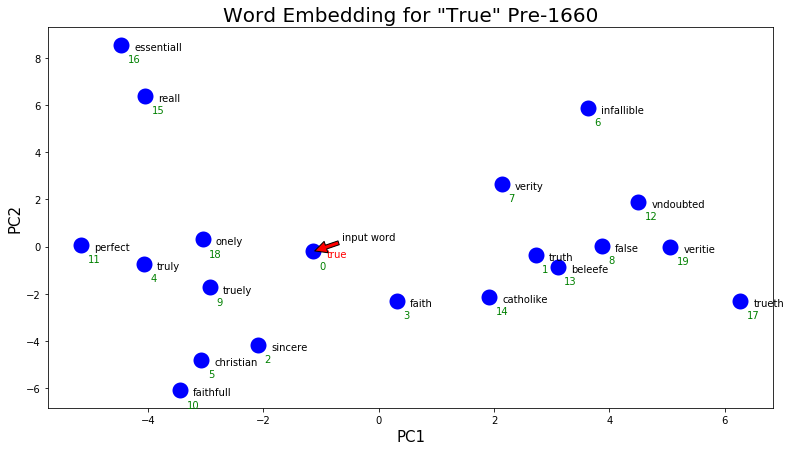

In [24]:
pre_true = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec true
pre_true = clean_output(pre_true)
words_dict = read_vec_file('embeddings/sgns_v1_v2_pre1660.vec')
visualize_embeddings(pre_true, 'true', words_dict, title='Word Embedding for "True" Pre-1660')

12.022654903721623
13.245121212359058


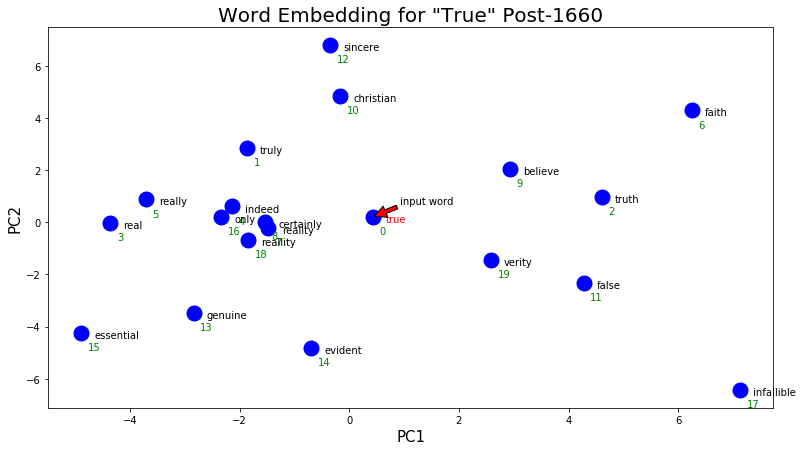

In [25]:
post_true = !python nearest.py embeddings/sgns_v1_v2_post1660.vec true
post_true = clean_output(post_true)
words_dict = read_vec_file('embeddings/sgns_v1_v2_post1660.vec')
visualize_embeddings(post_true, 'true', words_dict, title='Word Embedding for "True" Post-1660')

14.62286511256583
16.409843592606286


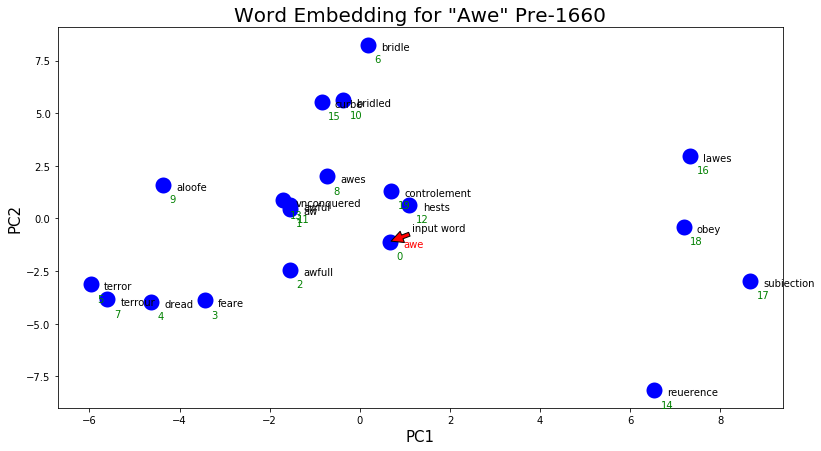

In [7]:
pre_awe = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec awe
pre_awe = clean_output(pre_awe)
words_dict = read_vec_file('embeddings/sgns_v1_v2_pre1660.vec')
visualize_embeddings(pre_awe, 'awe', words_dict, title='Word Embedding for "Awe" Pre-1660')

['awe', 'aw', 'awful', 'dread', 'awfull', 'reverence', 'awed', 'terror', 'reverential', 'terrour', 'fear', 'revere', "aw'd", 'slavish', 'subjection', 'jealous', 'servility', 'sway', 'disobey', 'obey']
47107
15.5307117104881
13.055259865510774


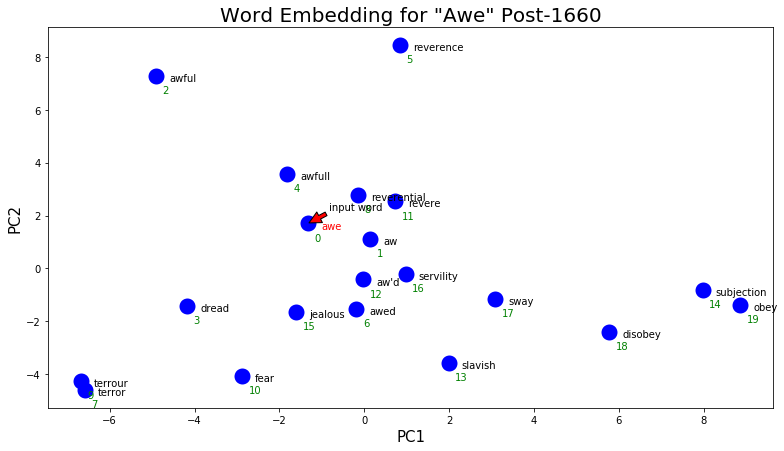

In [17]:
post_awe = !python nearest.py embeddings/sgns_v1_v2_post1660.vec awe
post_awe = clean_output(post_awe)
print(post_awe)
words_dict = read_vec_file('embeddings/sgns_v1_v2_post1660.vec')
print(len(words_dict))
visualize_embeddings(post_awe, 'awe', words_dict, title='Word Embedding for "Awe" Post-1660')

16.54113004139494
17.087018320832712


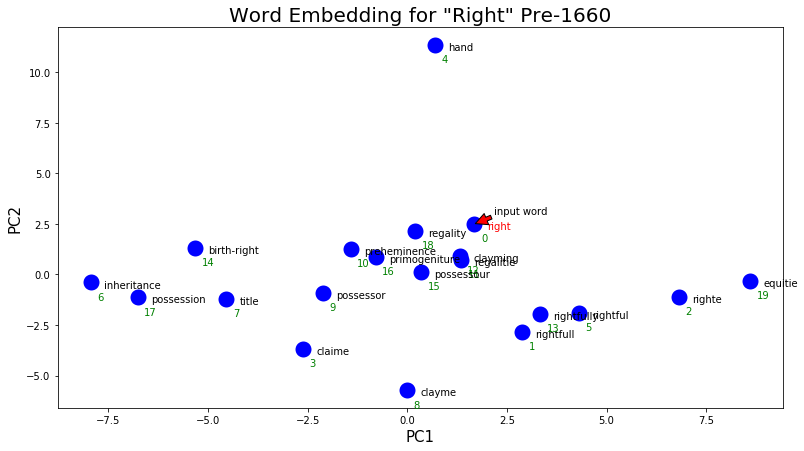

In [18]:
pre_right = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec right
pre_right = clean_output(pre_right)
words_dict = read_vec_file('embeddings/sgns_v1_v2_pre1660.vec')
visualize_embeddings(pre_right, 'right', words_dict, title='Word Embedding for "Right" Pre-1660')

15.319454154235144
10.699959211006494


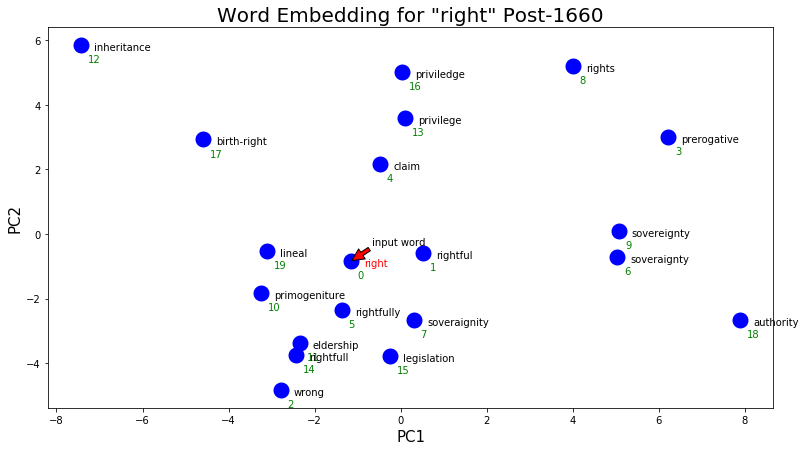

In [19]:
post_right = !python nearest.py embeddings/sgns_v1_v2_post1660.vec right
post_right = clean_output(post_right)
words_dict = read_vec_file('embeddings/sgns_v1_v2_post1660.vec')
visualize_embeddings(post_right, 'right', words_dict, title='Word Embedding for "right" Post-1660')

['1.000\tnatural', '0.731\tsupernatural', '0.712\tnaturall', '0.691\tinnate', '0.679\tadventitious', '0.678\tinternal', '0.678\tnature', '0.666\tvegetative', '0.663\thuman', '0.663\taptitude', '0.659\tintrinsecal', '0.657\ttemperament', '0.654\taccidental', '0.653\timplanted', '0.652\tphysical', '0.652\tmicrocosmicall', '0.651\tintellectual', '0.651\tvegetable', '0.647\tsensation', '0.645\tformative']
['natural', 'supernatural', 'naturall', 'innate', 'adventitious', 'internal', 'nature', 'vegetative', 'human', 'aptitude', 'intrinsecal', 'temperament', 'accidental', 'implanted', 'physical', 'microcosmicall', 'intellectual', 'vegetable', 'sensation', 'formative']
11.320082642044111
9.45423138764749


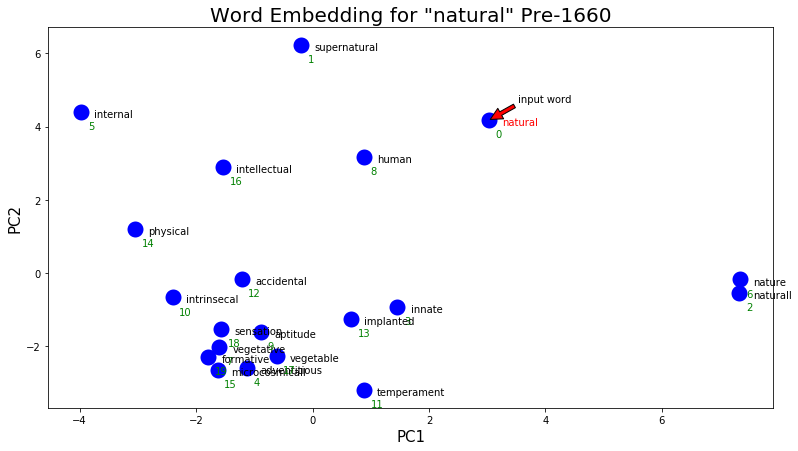

In [40]:
pre_real = !python nearest.py embeddings/sgns_v1_v2_pre1660.vec natural
print(pre_real)
pre_real = clean_output(pre_real)
print(pre_real)
words_dict = read_vec_file('embeddings/sgns_v1_v2_pre1660.vec')
visualize_embeddings(pre_real, 'natural', words_dict, title='Word Embedding for "natural" Pre-1660')

['1.000\tnatural', '0.763\tnature', '0.727\tnaturall', '0.694\tinbred', '0.676\tinnate', '0.670\tmoral', '0.659\thumane', '0.657\trational', '0.646\tnaturally', '0.644\thuman', '0.644\tinstincts', '0.640\tadventitious', '0.639\tsupernatural', '0.625\tconnatural', '0.623\tintellectual', '0.620\tpropensions', '0.618\tconsentaneous', '0.617\tcorporeal', '0.617\trepugnance', '0.607\tmorall']
['natural', 'nature', 'naturall', 'inbred', 'innate', 'moral', 'humane', 'rational', 'naturally', 'human', 'instincts', 'adventitious', 'supernatural', 'connatural', 'intellectual', 'propensions', 'consentaneous', 'corporeal', 'repugnance', 'morall']
9.931324555436948
11.840064720888883


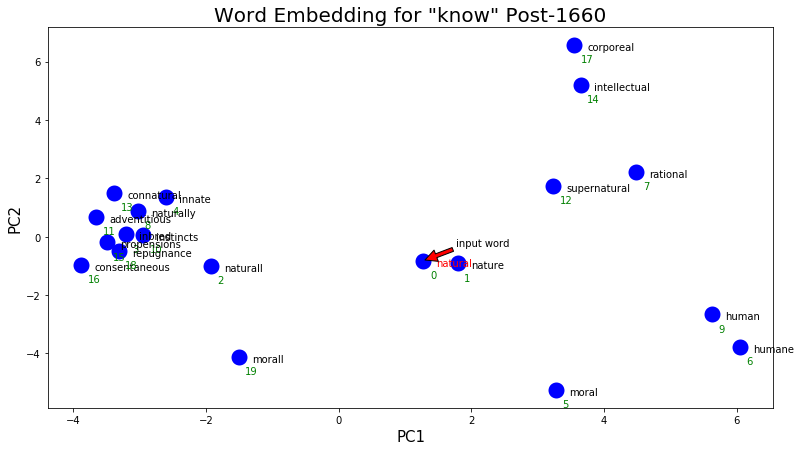

In [39]:
post_real = !python nearest.py embeddings/sgns_v1_v2_post1660.vec natural
print(post_real)
post_real = clean_output(post_real)
print(post_real)
words_dict = read_vec_file('embeddings/sgns_v1_v2_post1660.vec')
visualize_embeddings(post_real, 'natural', words_dict, title='Word Embedding for "know" Post-1660')

## Change in Language Over Time using EEBO
For each 20 year period in EEBO (1474-1700), we will calculate the top 100 most common words. Similarity between two consecutive time periods is measured by how much overlap in the top 100 most common words. 

In [43]:
# Start from 1470, end at 1710
# Parse in all filenames and years into a tuple list, then sort by year. 
date_tuples = []
for file in glob('date_txt/all/*.txt'):
    with open(file, 'r') as reader:
        if file == 'B01696':
            print
        year = int(reader.readline().strip())
        f_basename = Path(file).stem
        date_tuples.append((f_basename, year))

('A16110', 1639)


There are some texts outside of our date range so we will be filtering them out by strictly limiting our time period to 1470-1710. 

In [56]:
date_tuples.sort(key=lambda pair:pair[1])
print(f'The 10 earliest texts and dates are: \n{date_tuples[0:10]}\n')
print(f'The 10 latest texts and dates are: \n{date_tuples[-10:]}')

The 10 earliest texts and dates are: 
[('B01696', 16), ('B02239', 16), ('A89204', 169), ('A05232', 1473), ('A18343', 1474), ('A18231', 1476), ('A06567', 1476), ('A16385', 1477), ('A18230', 1477), ('A18294', 1477)]

The 10 latest texts and dates are: 
[('A52339', 1709), ('A46610', 1710), ('A52980', 1711), ('A57093', 1714), ('B03369', 1715), ('A67608', 1715), ('A44500', 1717), ('A42246', 1720), ('A11759', 1800), ('A57257', 1818)]


In [85]:
time_period = 1470
curr_file = 0
skipped = 0
INCREMENT = 10
stop_words = stopwords.words('english')
most_common_dict = dict() # key is start of time period, value is 100 most common words
for start_period in range(1470, 1710, INCREMENT):
    time_period_counter = Counter()
    print(f'Starting period {start_period}')
    while date_tuples[curr_file][1] < start_period + INCREMENT:
        # Find the corresponding text file
        basename = date_tuples[curr_file][0]
        filepath = os.path.join('no_punct', basename+'.headed.txt')
        if os.path.isfile(filepath):
            with open(filepath, 'r') as reader:
                for line in reader: 
                    line_tokens = [token for token in line.split(' ') if len(token) > 2 and token not in stop_words]
                    time_period_counter.update(line_tokens)
        else:
            skipped += 1
        curr_file += 1
    most_common_dict[start_period] = time_period_counter.most_common(100)
print(f'Skipped: {skipped}')

Starting period 1470
Starting period 1480
Starting period 1490
Starting period 1500
Starting period 1510
Starting period 1520
Starting period 1530
Starting period 1540
Starting period 1550
Starting period 1560
Starting period 1570
Starting period 1580
Starting period 1590
Starting period 1600
Starting period 1610
Starting period 1620
Starting period 1630
Starting period 1640
Starting period 1650
Starting period 1660
Starting period 1670
Starting period 1680
Starting period 1690
Starting period 1700
Skipped: 16979


In [86]:
pickle.dump(most_common_dict, open('most_common_dict.pkl', 'wb'))

In [87]:
most_common_dict = pickle.load(open('most_common_dict.pkl', 'rb'))

Similarity between 1480-1490 and 1490-1500: 39%

The similar words: {'alle', 'thy', 'moche', 'euery', 'per', 'tyme', 'fro', 'ben', 'maner', 'man', 'good', 'may', 'deth', 'body', 'therfore', 'haue', 'suche', 'god', 'hath', 'grete', 'whan', 'power', 'hem', 'make', 'noo', 'ther', 'many', 'thou', 'see', 'hym', 'also', 'cause', 'men', 'whiche', 'done', 'well', 'thus', 'shal', 'one'}


Similarity between 1490-1500 and 1500-1510: 46%

The similar words: {'alle', 'est', 'thenne', 'thy', 'moche', 'euery', 'per', 'tyme', 'fro', 'que', 'maner', 'man', 'good', 'ben', 'may', 'body', 'maye', 'therfore', 'haue', 'suche', 'god', 'hath', 'grete', 'whan', 'knowe', 'hem', 'make', 'ther', 'many', 'none', 'thou', 'yet', 'see', 'hym', 'also', 'cause', 'pro', 'men', 'whiche', 'ony', 'neuer', 'done', 'well', 'thus', 'shal', 'one'}


Similarity between 1500-1510 and 1510-1520: 34%

The similar words: {'moche', 'euery', 'thy', 'tyme', 'ben', 'maner', 'man', 'good', 'may', 'therfore', 'haue', 'suche', 'god', 'ha

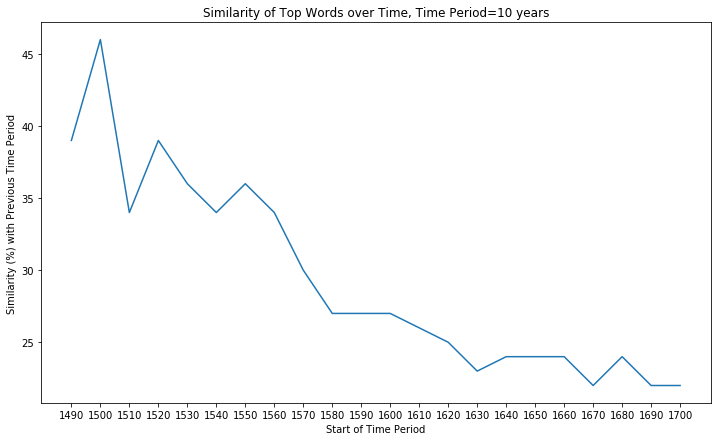

In [95]:
prev_words = [pair[0] for pair in most_common_dict[1470]]
dates = [x for x in range(1490, 1710, INCREMENT)]
similarities = []
for year in range(1490, 1710, INCREMENT): 
    curr_words = [pair[0] for pair in most_common_dict[year]]
    similarity = set(prev_words).intersection(set(curr_words))
    print(f"Similarity between {year-INCREMENT}-{year} and {year}-{year+INCREMENT}: {len(similarity)}%\n")
    print(f"The similar words: {similarity}\n\n")
    similarities.append(len(similarity))
    
plt.figure(figsize=(12,7))
plt.plot(dates,similarities)
plt.xticks(np.arange(min(dates), max(dates)+INCREMENT, INCREMENT))
plt.title(f'Similarity of Top Words over Time, Time Period={INCREMENT} years')
plt.xlabel('Start of Time Period')
plt.ylabel('Similarity (%) with Previous Time Period')
plt.show()
    